# 📊 Notebook 1: Exploratory Data Analysis (EDA)

## Military Object Detection Dataset

This notebook provides a comprehensive exploration of the military object detection dataset containing 12 classes of military and civilian objects.

### Objectives:
1. **Data Loading**: Load and verify dataset structure
2. **Class Distribution**: Analyze class imbalance
3. **Visualization**: Display samples with bounding boxes
4. **Bounding Box Analysis**: Study object sizes and positions
5. **Data Quality**: Identify potential issues

---

## 1. Setup & Imports

In [1]:
# Standard library imports
import os
import sys
from pathlib import Path
from collections import Counter, defaultdict
import warnings

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image

# Progress bar
from tqdm.notebook import tqdm

# YAML parsing
import yaml

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All imports successful!")

✅ All imports successful!


In [2]:
# Define paths
PROJECT_ROOT = Path('..')
DATASET_ROOT = PROJECT_ROOT / 'military_object_dataset'
CONFIG_PATH = PROJECT_ROOT / 'config' / 'dataset.yaml'

# Dataset splits
TRAIN_IMAGES = DATASET_ROOT / 'train' / 'images'
TRAIN_LABELS = DATASET_ROOT / 'train' / 'labels'
VAL_IMAGES = DATASET_ROOT / 'val' / 'images'
VAL_LABELS = DATASET_ROOT / 'val' / 'labels'
TEST_IMAGES = DATASET_ROOT / 'test' / 'images'

# Verify paths exist
paths_to_check = [
    ('Dataset Root', DATASET_ROOT),
    ('Train Images', TRAIN_IMAGES),
    ('Train Labels', TRAIN_LABELS),
    ('Val Images', VAL_IMAGES),
    ('Val Labels', VAL_LABELS),
    ('Test Images', TEST_IMAGES),
]

print("📁 Path Verification:")
print("-" * 50)
for name, path in paths_to_check:
    exists = "✅" if path.exists() else "❌"
    print(f"{exists} {name}: {path}")

📁 Path Verification:
--------------------------------------------------
✅ Dataset Root: ../military_object_dataset
✅ Train Images: ../military_object_dataset/train/images
✅ Train Labels: ../military_object_dataset/train/labels
✅ Val Images: ../military_object_dataset/val/images
✅ Val Labels: ../military_object_dataset/val/labels
✅ Test Images: ../military_object_dataset/test/images


In [3]:
# Load dataset configuration
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

# Extract class names
CLASS_NAMES = config['names']
NUM_CLASSES = config['nc']

print(f"📋 Dataset Configuration:")
print(f"   Number of classes: {NUM_CLASSES}")
print(f"\n🏷️ Class Names:")
for idx, name in CLASS_NAMES.items():
    print(f"   {idx:2d}: {name}")

📋 Dataset Configuration:
   Number of classes: 12

🏷️ Class Names:
    0: camouflage_soldier
    1: weapon
    2: military_tank
    3: military_truck
    4: military_vehicle
    5: civilian
    6: soldier
    7: civilian_vehicle
    8: military_artillery
    9: trench
   10: military_aircraft
   11: military_warship


## 2. Dataset Statistics

In [4]:
def count_files(directory: Path, extension: str = '*') -> int:
    """Count files with given extension in a directory."""
    if not directory.exists():
        return 0
    return len(list(directory.glob(f'*.{extension}')))

# Count files in each split
stats = {
    'Split': ['Train', 'Validation', 'Test'],
    'Images': [
        count_files(TRAIN_IMAGES, 'jpg'),
        count_files(VAL_IMAGES, 'jpg'),
        count_files(TEST_IMAGES, 'jpg')
    ],
    'Labels': [
        count_files(TRAIN_LABELS, 'txt'),
        count_files(VAL_LABELS, 'txt'),
        0  # Test set has no labels
    ]
}

stats_df = pd.DataFrame(stats)
stats_df['Has Labels'] = stats_df['Labels'] > 0

# Calculate totals
total_images = stats_df['Images'].sum()
total_labels = stats_df['Labels'].sum()

print("📊 Dataset Split Statistics:")
print("=" * 50)
display(stats_df)
print(f"\n📈 Total Images: {total_images:,}")
print(f"📈 Total Labels: {total_labels:,}")

📊 Dataset Split Statistics:


Split  Images  Labels  Has Labels
0       Train   10000   10000        True
1  Validation    2941    2941        True
2        Test    1396       0       False


📈 Total Images: 14,337
📈 Total Labels: 12,941


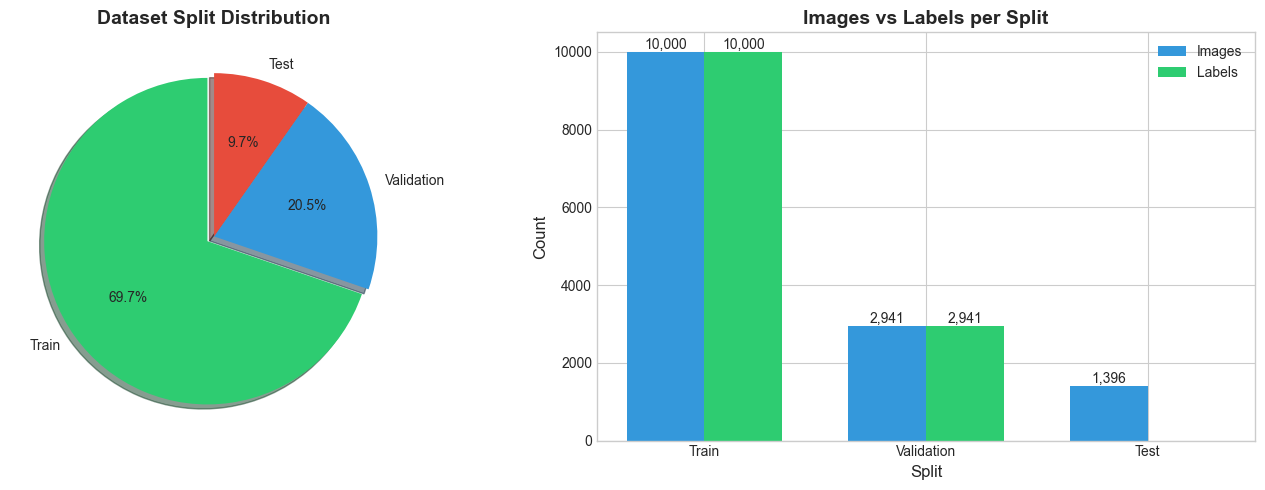

💾 Figure saved to: figures/01_dataset_splits.png


In [5]:
# Visualize dataset splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart for image distribution
colors = ['#2ecc71', '#3498db', '#e74c3c']
explode = (0.05, 0, 0)

axes[0].pie(
    stats_df['Images'], 
    labels=stats_df['Split'],
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    shadow=True,
    startangle=90
)
axes[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')

# Bar chart for detailed counts
x = np.arange(len(stats_df))
width = 0.35

bars1 = axes[1].bar(x - width/2, stats_df['Images'], width, label='Images', color='#3498db')
bars2 = axes[1].bar(x + width/2, stats_df['Labels'], width, label='Labels', color='#2ecc71')

axes[1].set_xlabel('Split', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Images vs Labels per Split', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(stats_df['Split'])
axes[1].legend()

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[1].annotate(f'{int(height):,}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        axes[1].annotate(f'{int(height):,}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/01_dataset_splits.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Figure saved to: figures/01_dataset_splits.png")

## 3. Class Distribution Analysis

In [6]:
def parse_label_file(label_path: Path) -> list:
    """Parse a YOLO format label file.
    
    Returns:
        List of tuples (class_id, x_center, y_center, width, height)
    """
    annotations = []
    
    if not label_path.exists():
        return annotations
    
    with open(label_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            parts = line.split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                annotations.append((class_id, x_center, y_center, width, height))
    
    return annotations


def collect_all_annotations(labels_dir: Path) -> tuple:
    """Collect all annotations from a labels directory.
    
    Returns:
        (class_counts, all_annotations, objects_per_image)
    """
    class_counts = Counter()
    all_annotations = []
    objects_per_image = []
    
    label_files = list(labels_dir.glob('*.txt'))
    
    for label_path in tqdm(label_files, desc="Parsing labels"):
        annotations = parse_label_file(label_path)
        objects_per_image.append(len(annotations))
        
        for ann in annotations:
            class_id = ann[0]
            class_counts[class_id] += 1
            all_annotations.append({
                'class_id': class_id,
                'class_name': CLASS_NAMES.get(class_id, 'unknown'),
                'x_center': ann[1],
                'y_center': ann[2],
                'width': ann[3],
                'height': ann[4],
                'area': ann[3] * ann[4],
                'aspect_ratio': ann[3] / ann[4] if ann[4] > 0 else 0,
                'file': label_path.stem
            })
    
    return class_counts, all_annotations, objects_per_image

In [7]:
# Collect annotations from training set
print("🔍 Analyzing training set annotations...")
train_class_counts, train_annotations, train_objects_per_image = collect_all_annotations(TRAIN_LABELS)

# Create annotations DataFrame
annotations_df = pd.DataFrame(train_annotations)

print(f"\n📊 Training Set Summary:")
print(f"   Total annotations: {len(annotations_df):,}")
print(f"   Total images with labels: {len(train_objects_per_image):,}")
print(f"   Average objects per image: {np.mean(train_objects_per_image):.2f}")
print(f"   Max objects in single image: {max(train_objects_per_image)}")

🔍 Analyzing training set annotations...


Parsing labels:   0%|          | 0/10000 [00:00<?, ?it/s]


📊 Training Set Summary:
   Total annotations: 19,956
   Total images with labels: 10,000
   Average objects per image: 2.00
   Max objects in single image: 86


In [8]:
# Create class distribution DataFrame
class_dist = []
for class_id, count in sorted(train_class_counts.items()):
    class_dist.append({
        'Class ID': class_id,
        'Class Name': CLASS_NAMES.get(class_id, 'unknown'),
        'Count': count,
        'Percentage': count / sum(train_class_counts.values()) * 100
    })

class_dist_df = pd.DataFrame(class_dist)
class_dist_df = class_dist_df.sort_values('Count', ascending=False).reset_index(drop=True)

# Calculate imbalance ratio
max_count = class_dist_df['Count'].max()
min_count = class_dist_df['Count'].min()
imbalance_ratio = max_count / min_count

print("📊 Class Distribution (Training Set):")
print("=" * 60)
display(class_dist_df)
print(f"\n⚠️ Imbalance Ratio: {imbalance_ratio:.0f}:1 (max/min)")

📊 Class Distribution (Training Set):


Class ID          Class Name  Count  Percentage
0          2       military_tank   7822   39.196232
1         10   military_aircraft   3510   17.588695
2          6             soldier   2991   14.987974
3          0  camouflage_soldier   2070   10.372820
4          4    military_vehicle    947    4.745440
5         11    military_warship    923    4.625175
6          3      military_truck    623    3.121868
7          1              weapon    541    2.710964
8          7    civilian_vehicle    270    1.352977
9          8  military_artillery    239    1.197635
10         5            civilian     18    0.090198
11         9              trench      2    0.010022


⚠️ Imbalance Ratio: 3911:1 (max/min)


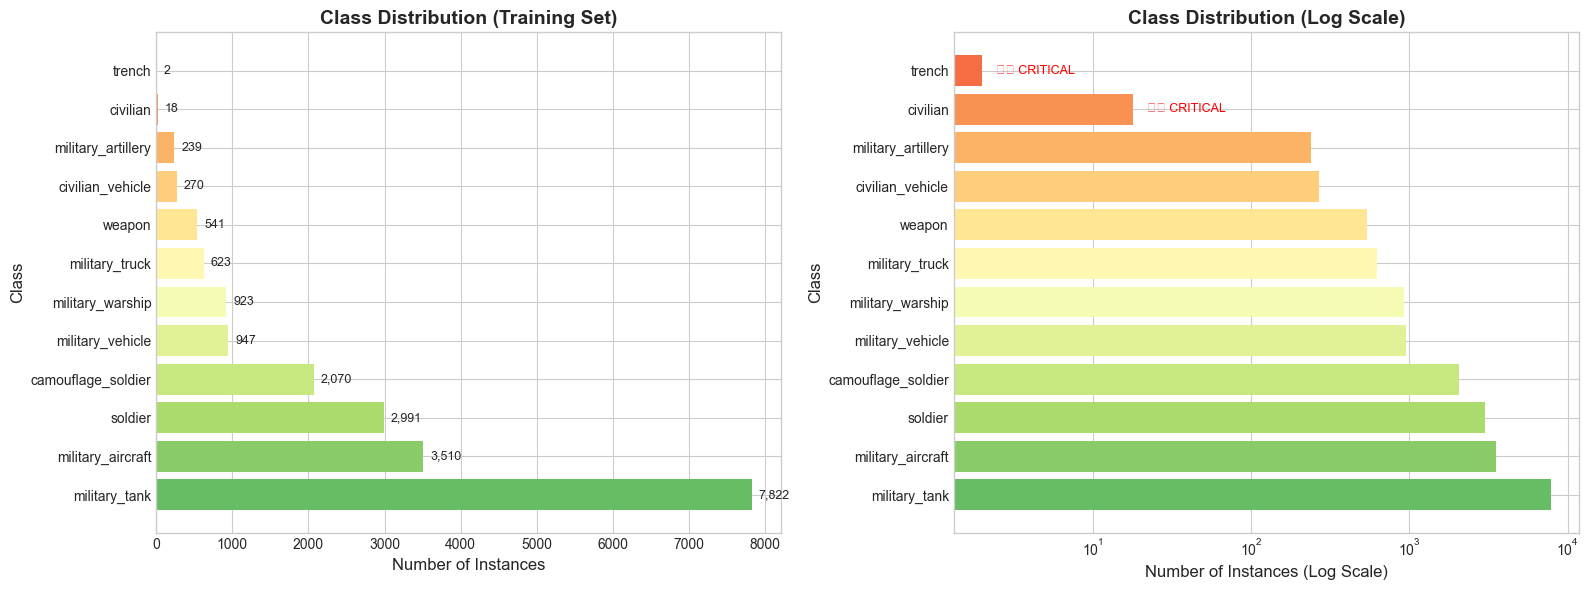

💾 Figure saved to: figures/02_class_distribution.png


In [9]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart (sorted by count)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(class_dist_df)))[::-1]

bars = axes[0].barh(
    class_dist_df['Class Name'], 
    class_dist_df['Count'],
    color=colors
)

axes[0].set_xlabel('Number of Instances', fontsize=12)
axes[0].set_ylabel('Class', fontsize=12)
axes[0].set_title('Class Distribution (Training Set)', fontsize=14, fontweight='bold')

# Add count labels
for bar, count in zip(bars, class_dist_df['Count']):
    axes[0].annotate(f'{count:,}',
                     xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                     ha='left', va='center', fontsize=9,
                     xytext=(5, 0), textcoords='offset points')

# Log scale bar chart to show minority classes
bars2 = axes[1].barh(
    class_dist_df['Class Name'], 
    class_dist_df['Count'],
    color=colors
)
axes[1].set_xscale('log')
axes[1].set_xlabel('Number of Instances (Log Scale)', fontsize=12)
axes[1].set_ylabel('Class', fontsize=12)
axes[1].set_title('Class Distribution (Log Scale)', fontsize=14, fontweight='bold')

# Mark critically under-represented classes
critical_threshold = 50
for idx, row in class_dist_df.iterrows():
    if row['Count'] < critical_threshold:
        axes[1].annotate('⚠️ CRITICAL',
                         xy=(row['Count'], idx),
                         ha='left', va='center', fontsize=9, color='red',
                         xytext=(10, 0), textcoords='offset points')

plt.tight_layout()
plt.savefig('../figures/02_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Figure saved to: figures/02_class_distribution.png")

In [10]:
# Calculate and display class weights for handling imbalance
total_instances = class_dist_df['Count'].sum()

# Method 1: Inverse frequency
class_dist_df['Weight (Inv Freq)'] = total_instances / (NUM_CLASSES * class_dist_df['Count'])

# Method 2: Square root scaling (less aggressive)
class_dist_df['Weight (Sqrt)'] = np.sqrt(class_dist_df['Weight (Inv Freq)'])

# Normalize weights
class_dist_df['Weight (Inv Freq)'] = class_dist_df['Weight (Inv Freq)'] / class_dist_df['Weight (Inv Freq)'].mean()
class_dist_df['Weight (Sqrt)'] = class_dist_df['Weight (Sqrt)'] / class_dist_df['Weight (Sqrt)'].mean()

print("⚖️ Suggested Class Weights for Training:")
print("=" * 80)
weight_display = class_dist_df[['Class ID', 'Class Name', 'Count', 'Weight (Inv Freq)', 'Weight (Sqrt)']].copy()
weight_display = weight_display.sort_values('Class ID')
display(weight_display.round(3))

⚖️ Suggested Class Weights for Training:


Class ID          Class Name  Count  Weight (Inv Freq)  Weight (Sqrt)
3          0  camouflage_soldier   2070              0.010          0.205
7          1              weapon    541              0.039          0.401
0          2       military_tank   7822              0.003          0.106
6          3      military_truck    623              0.034          0.374
4          4    military_vehicle    947              0.022          0.303
10         5            civilian     18              1.169          2.201
2          6             soldier   2991              0.007          0.171
8          7    civilian_vehicle    270              0.078          0.568
9          8  military_artillery    239              0.088          0.604
11         9              trench      2             10.521          6.602
1         10   military_aircraft   3510              0.006          0.158
5         11    military_warship    923              0.023          0.307

## 4. Sample Visualization with Bounding Boxes

In [11]:
# Color palette for classes
CLASS_COLORS = {
    0: '#e74c3c',   # camouflage_soldier - red
    1: '#e67e22',   # weapon - orange
    2: '#2ecc71',   # military_tank - green
    3: '#27ae60',   # military_truck - dark green
    4: '#3498db',   # military_vehicle - blue
    5: '#9b59b6',   # civilian - purple
    6: '#f39c12',   # soldier - yellow
    7: '#1abc9c',   # civilian_vehicle - teal
    8: '#34495e',   # military_artillery - dark gray
    9: '#95a5a6',   # trench - gray
    10: '#d35400',  # military_aircraft - dark orange
    11: '#2980b9',  # military_warship - dark blue
}


def visualize_sample(image_path: Path, label_path: Path, ax=None, show_labels: bool = True):
    """Visualize an image with its bounding boxes."""
    # Load image
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    ax.imshow(img)
    
    # Parse and draw bounding boxes
    annotations = parse_label_file(label_path)
    
    for ann in annotations:
        class_id, x_center, y_center, width, height = ann
        
        # Convert YOLO format to pixel coordinates
        x1 = (x_center - width / 2) * img_width
        y1 = (y_center - height / 2) * img_height
        box_width = width * img_width
        box_height = height * img_height
        
        # Get color for class
        color = CLASS_COLORS.get(class_id, '#ffffff')
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), box_width, box_height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        if show_labels:
            class_name = CLASS_NAMES.get(class_id, 'unknown')
            ax.text(
                x1, y1 - 5, class_name,
                color='white', fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8)
            )
    
    ax.axis('off')
    ax.set_title(f"{image_path.name} ({len(annotations)} objects)", fontsize=10)
    
    return ax

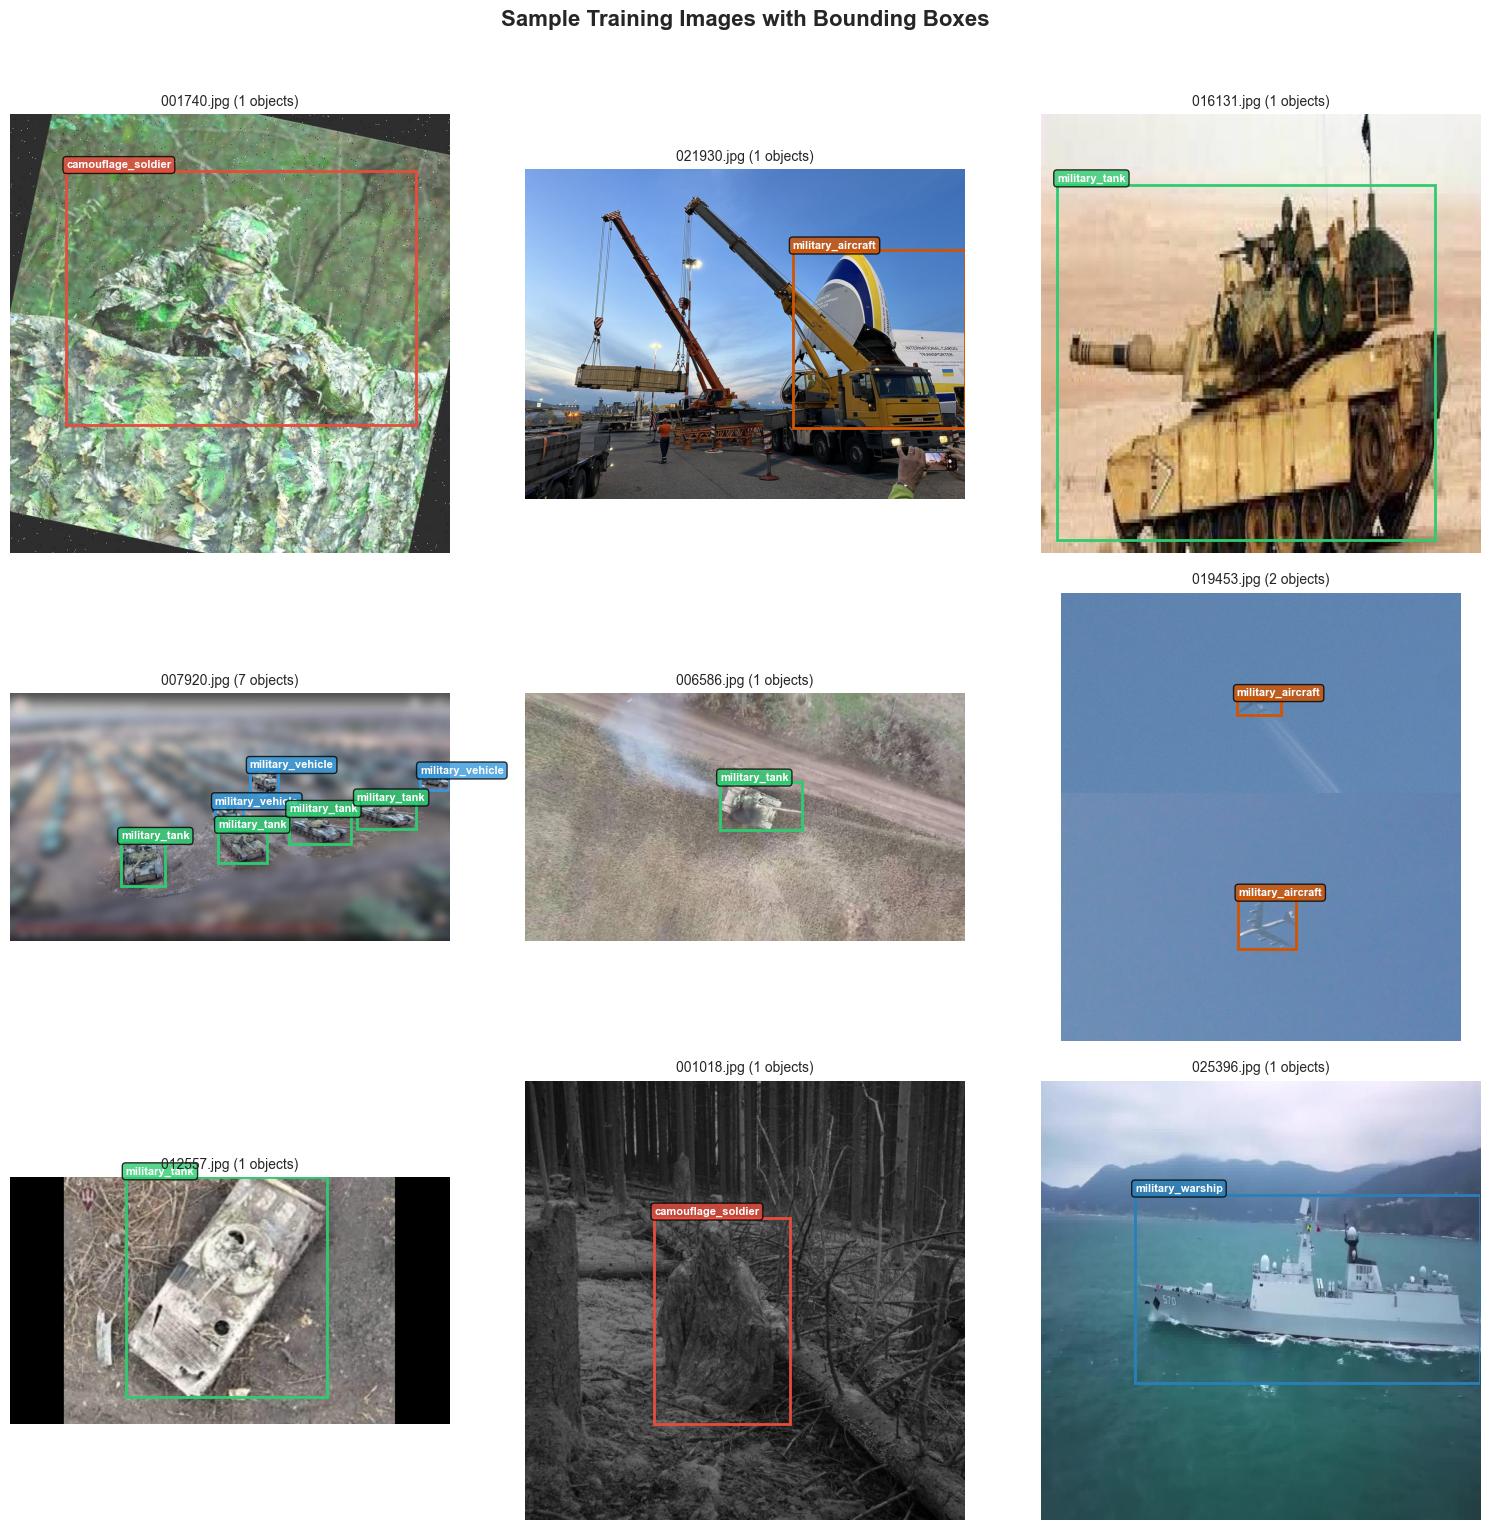

💾 Figure saved to: figures/03_sample_visualizations.png


In [12]:
# Visualize random samples from training set
np.random.seed(42)

# Get list of all training images
train_images = list(TRAIN_IMAGES.glob('*.jpg'))
sample_images = np.random.choice(train_images, size=min(9, len(train_images)), replace=False)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    label_path = TRAIN_LABELS / f"{img_path.stem}.txt"
    visualize_sample(img_path, label_path, ax=axes[idx])

plt.suptitle('Sample Training Images with Bounding Boxes', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/03_sample_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Figure saved to: figures/03_sample_visualizations.png")

🔍 Finding samples for each class...


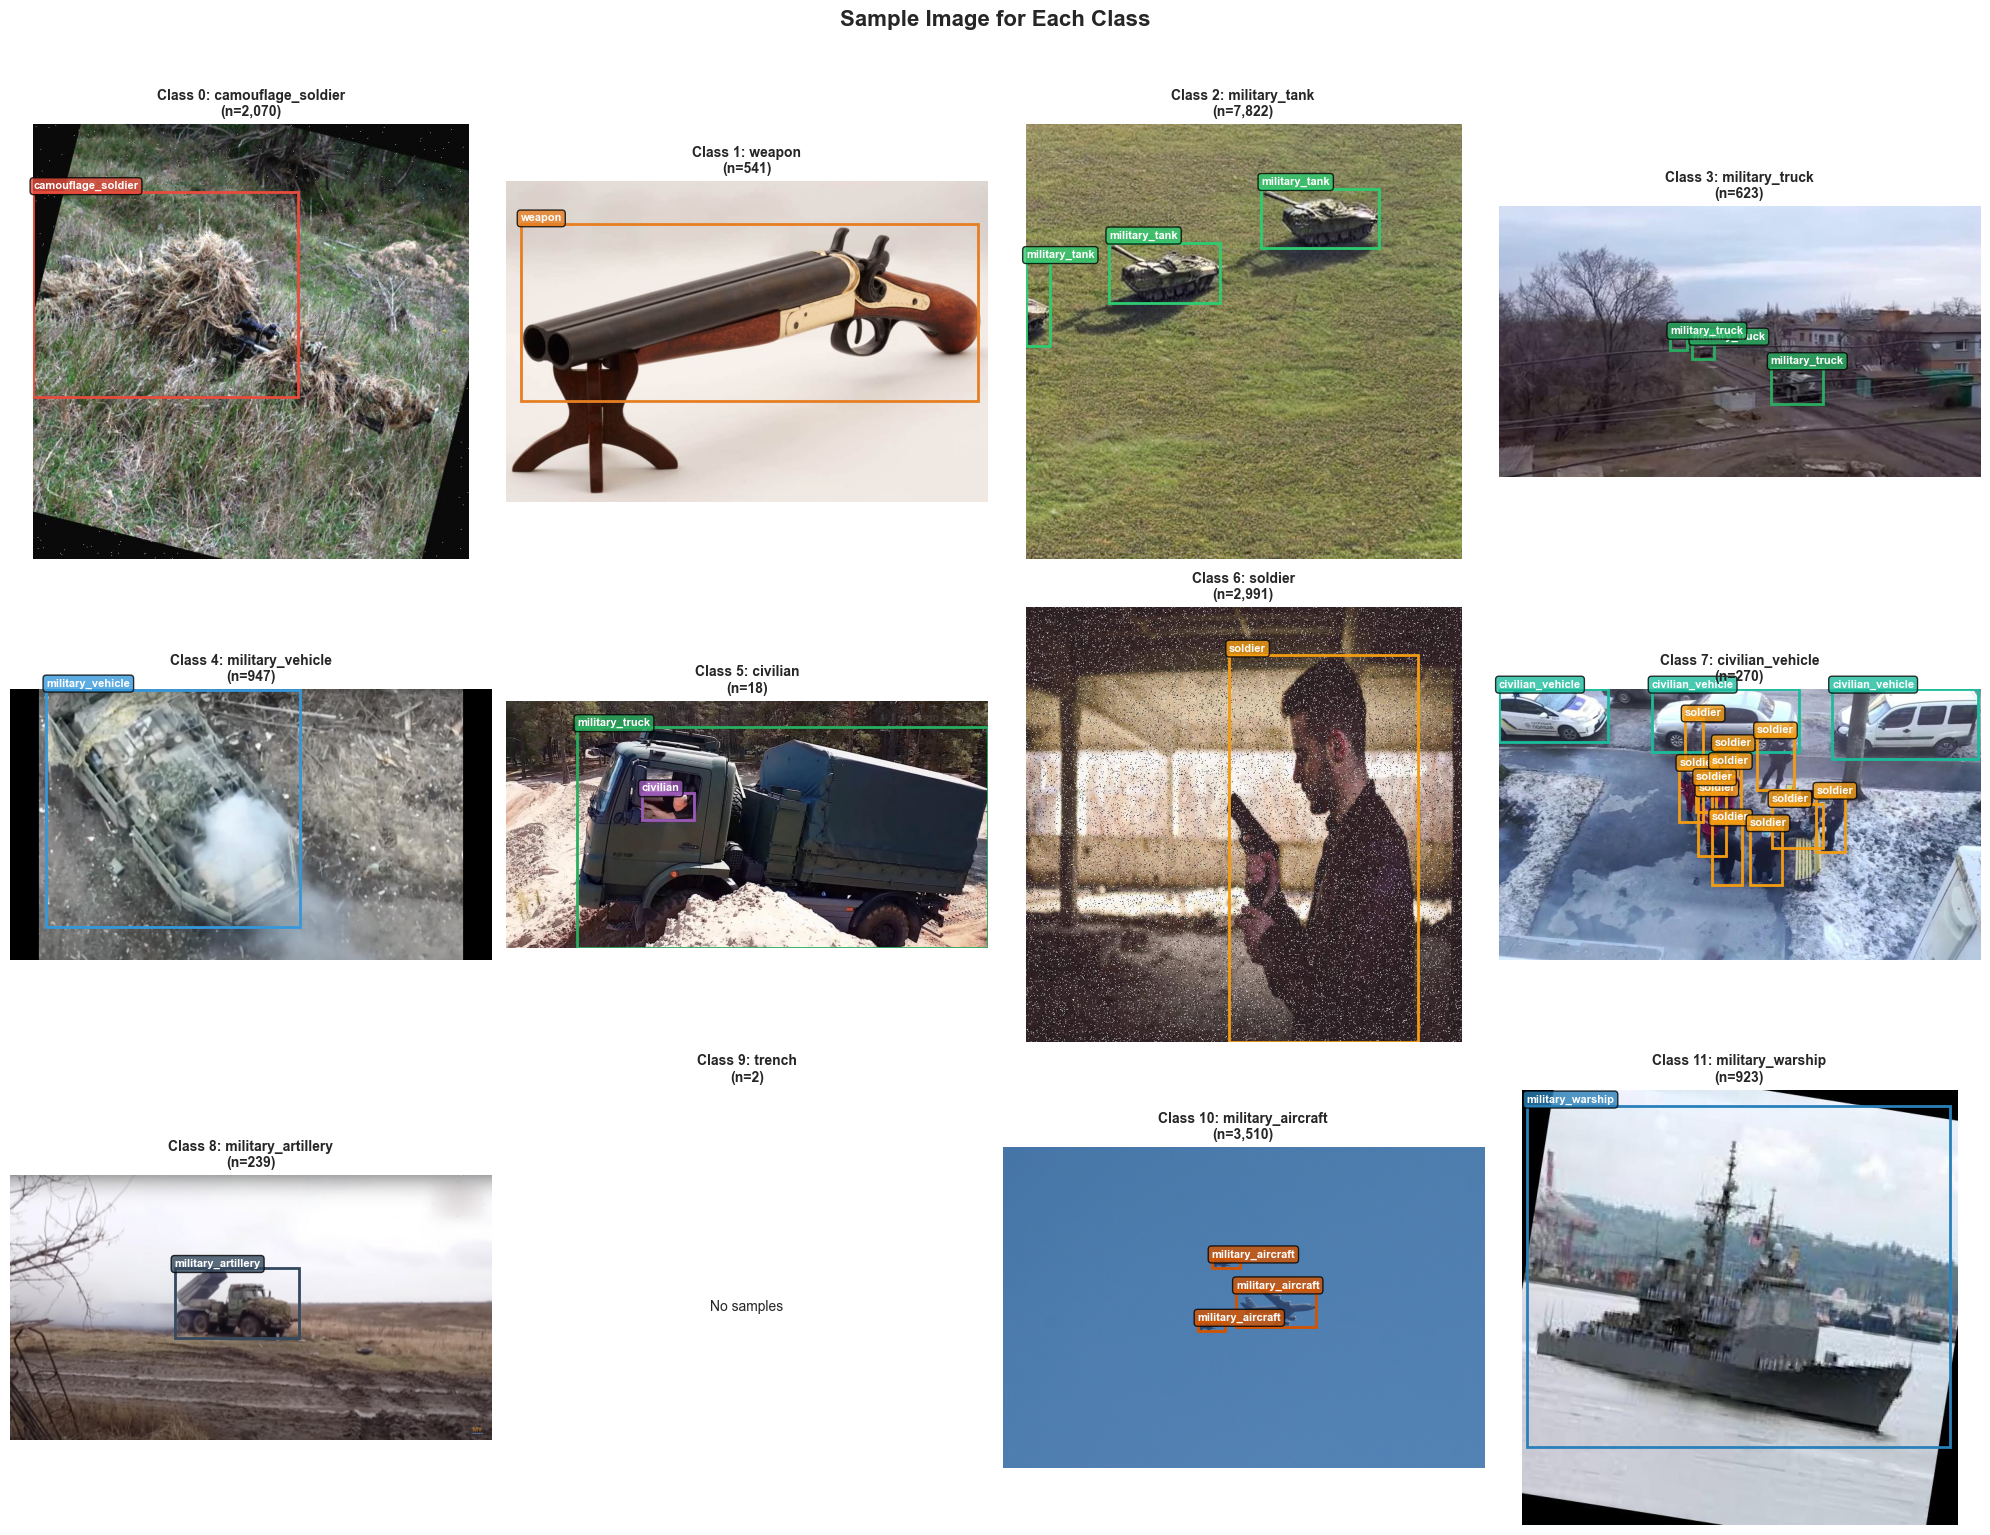

💾 Figure saved to: figures/04_class_samples.png


In [13]:
# Visualize samples from each class
print("🔍 Finding samples for each class...")

# Group files by class
class_samples = defaultdict(list)

for _, row in annotations_df.groupby('file').first().reset_index().iterrows():
    file_name = row['file']
    class_id = row['class_id']
    class_samples[class_id].append(file_name)

# Show one sample per class
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for class_id in range(NUM_CLASSES):
    ax = axes[class_id]
    
    if class_id in class_samples and len(class_samples[class_id]) > 0:
        sample_file = np.random.choice(class_samples[class_id])
        img_path = TRAIN_IMAGES / f"{sample_file}.jpg"
        label_path = TRAIN_LABELS / f"{sample_file}.txt"
        
        if img_path.exists():
            visualize_sample(img_path, label_path, ax=ax)
        else:
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
            ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'No samples', ha='center', va='center')
        ax.axis('off')
    
    class_name = CLASS_NAMES.get(class_id, 'unknown')
    count = train_class_counts.get(class_id, 0)
    ax.set_title(f"Class {class_id}: {class_name}\n(n={count:,})", fontsize=10, fontweight='bold')

plt.suptitle('Sample Image for Each Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/04_class_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Figure saved to: figures/04_class_samples.png")

## 5. Bounding Box Analysis

In [14]:
# Analyze bounding box statistics
print("📊 Bounding Box Statistics:")
print("=" * 50)

bbox_stats = annotations_df[['width', 'height', 'area', 'aspect_ratio']].describe()
display(bbox_stats.round(4))

📊 Bounding Box Statistics:


width      height        area  aspect_ratio
count  19956.0000  19956.0000  19956.0000    19956.0000
mean       0.2977      0.3091      0.1497        1.0916
std        0.2825      0.2752      0.2180        0.7589
min        0.0000      0.0000      0.0000        0.0000
25%        0.0743      0.0840      0.0067        0.5818
50%        0.1853      0.2031      0.0372        0.9308
75%        0.4531      0.4785      0.2111        1.3824
max        1.0000      1.0000      1.0000        9.7690

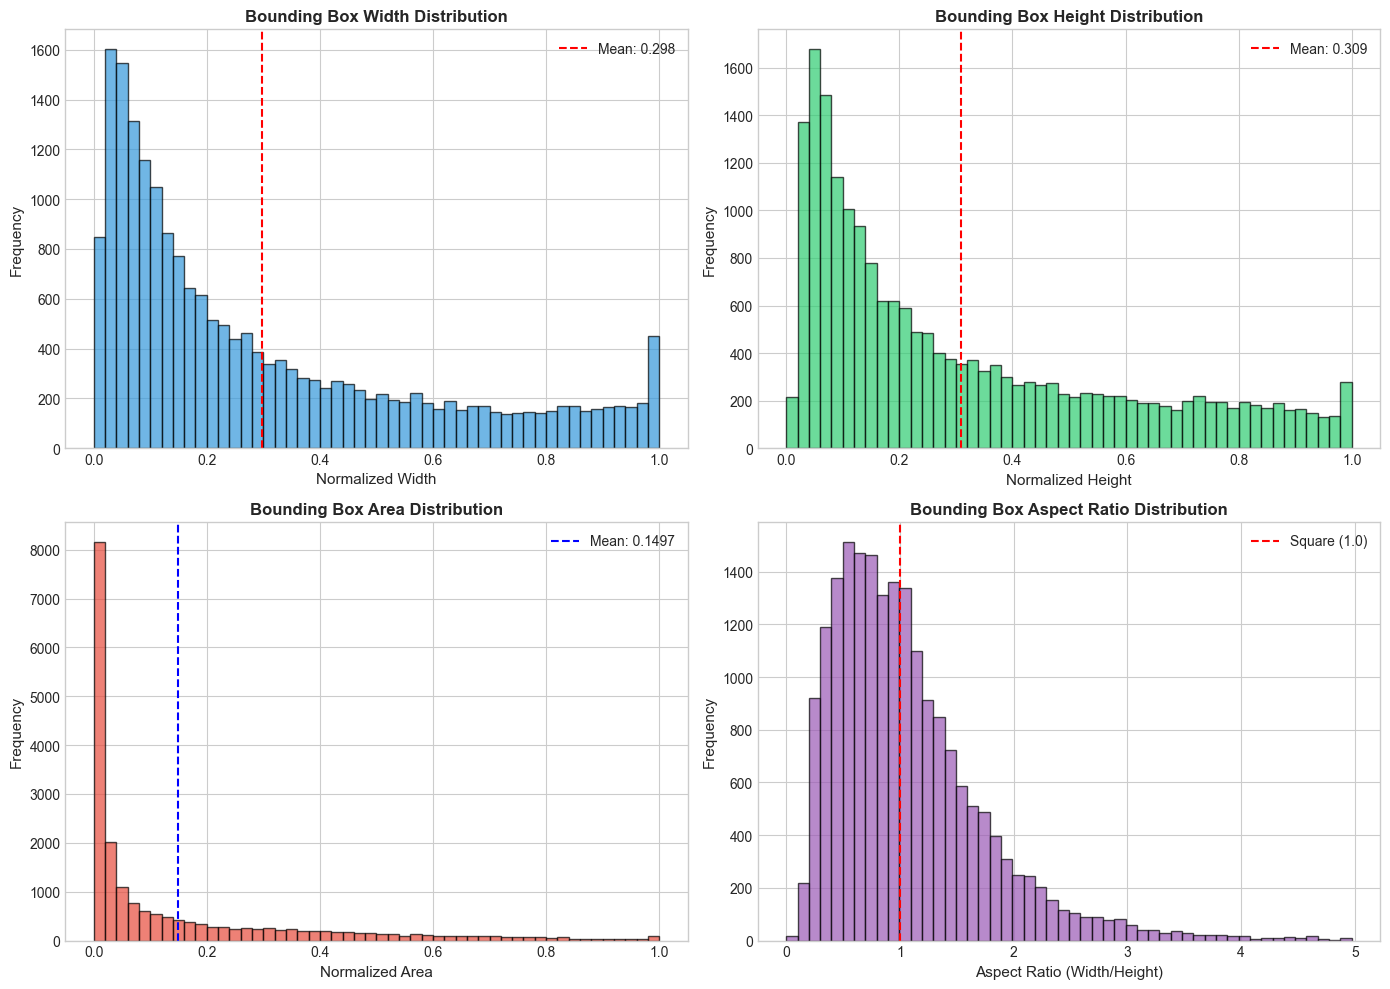

💾 Figure saved to: figures/05_bbox_distributions.png


In [15]:
# Visualize bounding box distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Width distribution
axes[0, 0].hist(annotations_df['width'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Normalized Width', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Bounding Box Width Distribution', fontsize=12, fontweight='bold')
axes[0, 0].axvline(annotations_df['width'].mean(), color='red', linestyle='--', label=f"Mean: {annotations_df['width'].mean():.3f}")
axes[0, 0].legend()

# Height distribution
axes[0, 1].hist(annotations_df['height'], bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Normalized Height', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Bounding Box Height Distribution', fontsize=12, fontweight='bold')
axes[0, 1].axvline(annotations_df['height'].mean(), color='red', linestyle='--', label=f"Mean: {annotations_df['height'].mean():.3f}")
axes[0, 1].legend()

# Area distribution
axes[1, 0].hist(annotations_df['area'], bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Normalized Area', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Bounding Box Area Distribution', fontsize=12, fontweight='bold')
axes[1, 0].axvline(annotations_df['area'].mean(), color='blue', linestyle='--', label=f"Mean: {annotations_df['area'].mean():.4f}")
axes[1, 0].legend()

# Aspect ratio distribution
# Filter out extreme values for better visualization
ar_filtered = annotations_df['aspect_ratio'][annotations_df['aspect_ratio'] < 5]
axes[1, 1].hist(ar_filtered, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Aspect Ratio (Width/Height)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Bounding Box Aspect Ratio Distribution', fontsize=12, fontweight='bold')
axes[1, 1].axvline(1.0, color='red', linestyle='--', label='Square (1.0)')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../figures/05_bbox_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Figure saved to: figures/05_bbox_distributions.png")

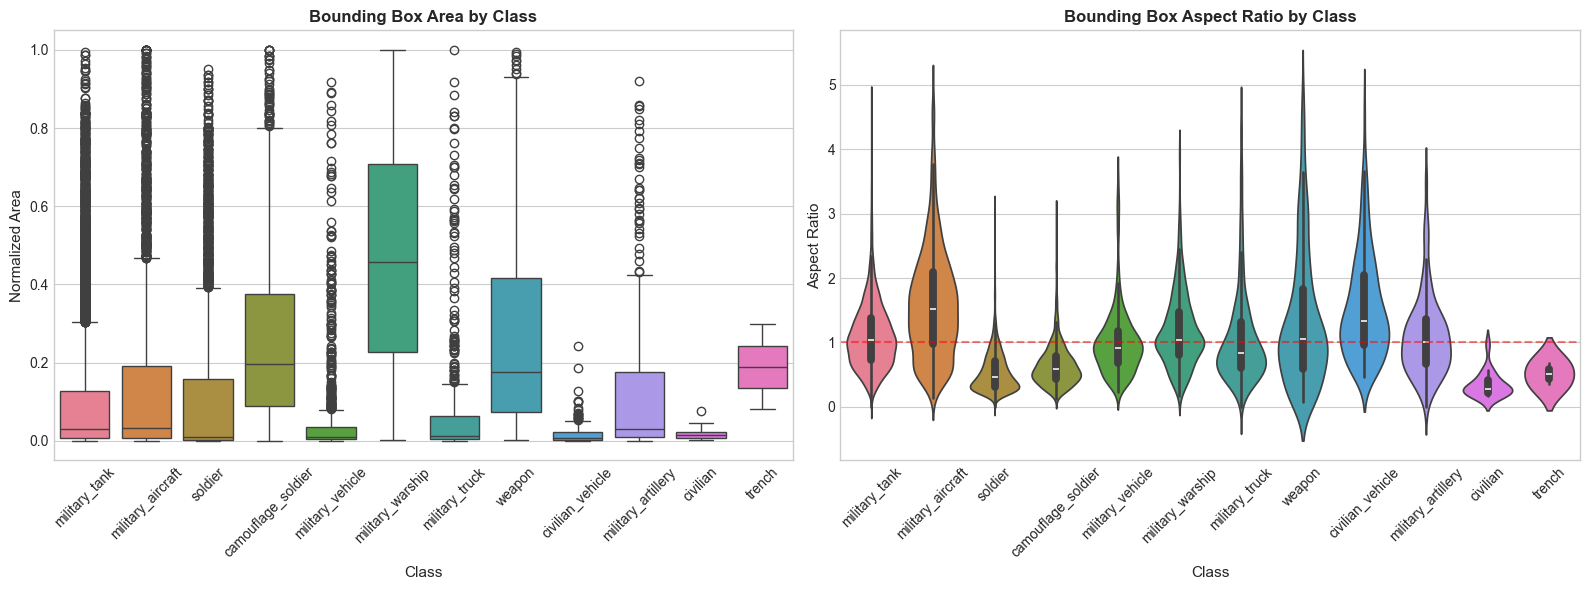

💾 Figure saved to: figures/06_bbox_by_class.png


In [16]:
# Bounding box size analysis by class
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot of areas by class
class_order = class_dist_df.sort_values('Count', ascending=False)['Class Name'].tolist()

sns.boxplot(
    data=annotations_df, 
    x='class_name', 
    y='area',
    order=class_order,
    ax=axes[0],
    palette='husl'
)
axes[0].set_xlabel('Class', fontsize=11)
axes[0].set_ylabel('Normalized Area', fontsize=11)
axes[0].set_title('Bounding Box Area by Class', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Violin plot of aspect ratios
ar_data = annotations_df[annotations_df['aspect_ratio'] < 5].copy()
sns.violinplot(
    data=ar_data, 
    x='class_name', 
    y='aspect_ratio',
    order=class_order,
    ax=axes[1],
    palette='husl'
)
axes[1].set_xlabel('Class', fontsize=11)
axes[1].set_ylabel('Aspect Ratio', fontsize=11)
axes[1].set_title('Bounding Box Aspect Ratio by Class', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../figures/06_bbox_by_class.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Figure saved to: figures/06_bbox_by_class.png")

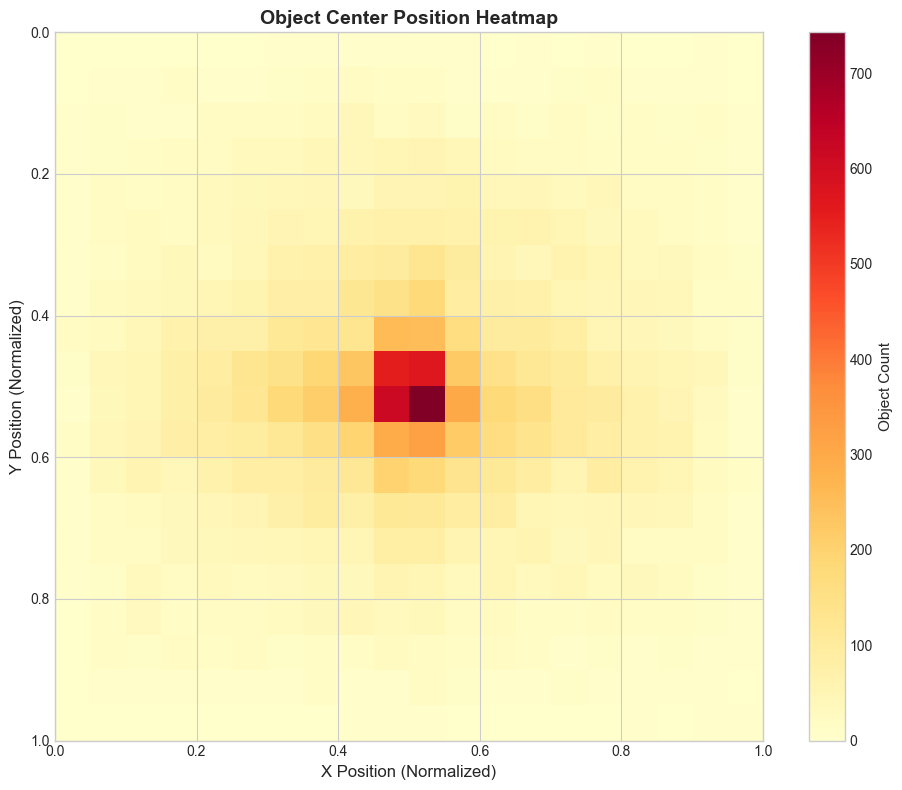

💾 Figure saved to: figures/07_position_heatmap.png


In [17]:
# Analyze object position distribution (heatmap)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Create 2D histogram of object centers
heatmap, xedges, yedges = np.histogram2d(
    annotations_df['x_center'], 
    annotations_df['y_center'], 
    bins=20,
    range=[[0, 1], [0, 1]]
)

# Plot heatmap (transposed and flipped for correct orientation)
im = ax.imshow(
    heatmap.T, 
    extent=[0, 1, 1, 0],
    cmap='YlOrRd',
    aspect='equal'
)

ax.set_xlabel('X Position (Normalized)', fontsize=12)
ax.set_ylabel('Y Position (Normalized)', fontsize=12)
ax.set_title('Object Center Position Heatmap', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Object Count', fontsize=11)

plt.tight_layout()
plt.savefig('../figures/07_position_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Figure saved to: figures/07_position_heatmap.png")

## 6. Objects Per Image Distribution

In [18]:
# Analyze objects per image
objects_per_image_series = pd.Series(train_objects_per_image)

print("📊 Objects Per Image Statistics:")
print("=" * 50)
print(f"   Mean: {objects_per_image_series.mean():.2f}")
print(f"   Median: {objects_per_image_series.median():.2f}")
print(f"   Std Dev: {objects_per_image_series.std():.2f}")
print(f"   Min: {objects_per_image_series.min()}")
print(f"   Max: {objects_per_image_series.max()}")
print(f"   Images with 0 objects: {(objects_per_image_series == 0).sum()}")

📊 Objects Per Image Statistics:
   Mean: 2.00
   Median: 1.00
   Std Dev: 2.85
   Min: 0
   Max: 86
   Images with 0 objects: 123


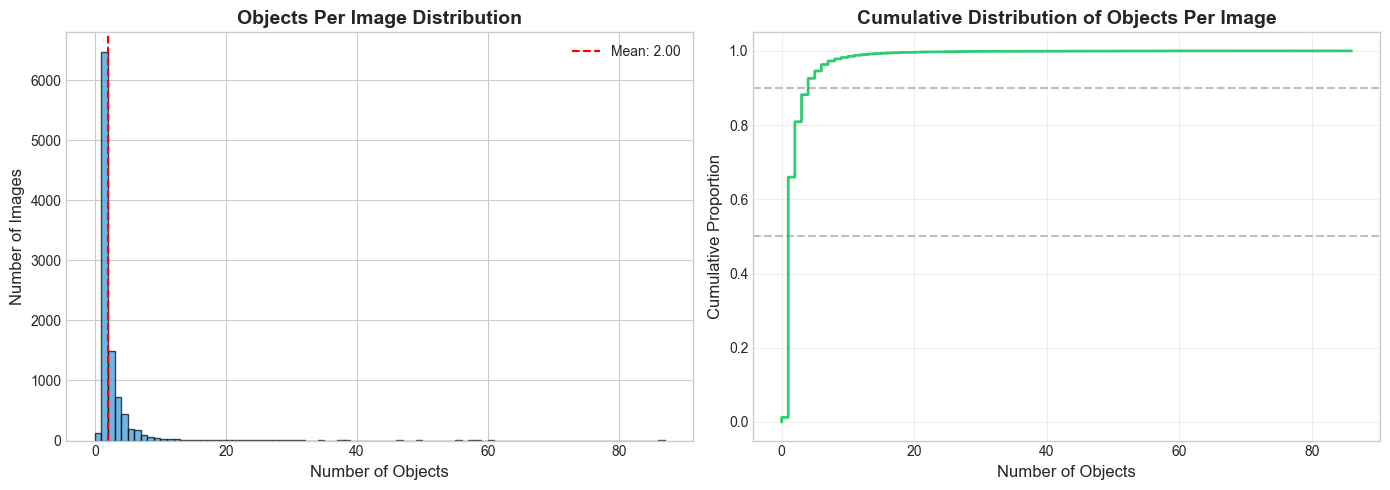

💾 Figure saved to: figures/08_objects_per_image.png


In [19]:
# Visualize objects per image distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(objects_per_image_series, bins=range(0, max(train_objects_per_image) + 2), 
             color='#3498db', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Objects', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_title('Objects Per Image Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(objects_per_image_series.mean(), color='red', linestyle='--', 
                label=f"Mean: {objects_per_image_series.mean():.2f}")
axes[0].legend()

# Cumulative distribution
sorted_data = np.sort(objects_per_image_series)
cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

axes[1].plot(sorted_data, cumulative, color='#2ecc71', linewidth=2)
axes[1].set_xlabel('Number of Objects', fontsize=12)
axes[1].set_ylabel('Cumulative Proportion', fontsize=12)
axes[1].set_title('Cumulative Distribution of Objects Per Image', fontsize=14, fontweight='bold')
axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(0.9, color='gray', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/08_objects_per_image.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Figure saved to: figures/08_objects_per_image.png")

## 7. Data Quality Assessment

In [20]:
def check_data_quality(images_dir: Path, labels_dir: Path, split_name: str) -> dict:
    """Perform comprehensive data quality checks."""
    issues = {
        'missing_labels': [],
        'missing_images': [],
        'empty_labels': [],
        'invalid_bbox': [],
        'invalid_class': [],
        'corrupted_images': []
    }
    
    # Get all files
    image_files = {f.stem for f in images_dir.glob('*.jpg')}
    label_files = {f.stem for f in labels_dir.glob('*.txt')}
    
    # Check for missing labels
    issues['missing_labels'] = list(image_files - label_files)
    
    # Check for missing images
    issues['missing_images'] = list(label_files - image_files)
    
    # Check each label file
    for label_file in tqdm(list(labels_dir.glob('*.txt')), desc=f"Checking {split_name}"):
        annotations = parse_label_file(label_file)
        
        # Empty label file
        if len(annotations) == 0:
            issues['empty_labels'].append(label_file.stem)
            continue
        
        for ann in annotations:
            class_id, x, y, w, h = ann
            
            # Invalid class ID
            if class_id < 0 or class_id >= NUM_CLASSES:
                issues['invalid_class'].append((label_file.stem, class_id))
            
            # Invalid bounding box (out of bounds or negative dimensions)
            if not (0 <= x <= 1 and 0 <= y <= 1 and 0 < w <= 1 and 0 < h <= 1):
                issues['invalid_bbox'].append((label_file.stem, ann))
    
    # Check for corrupted images (sample check)
    sample_images = list(images_dir.glob('*.jpg'))[:100]  # Check first 100
    for img_path in sample_images:
        try:
            with Image.open(img_path) as img:
                img.verify()
        except Exception as e:
            issues['corrupted_images'].append(str(img_path))
    
    return issues

In [21]:
# Run quality checks on training data
print("🔍 Running data quality checks...")
train_issues = check_data_quality(TRAIN_IMAGES, TRAIN_LABELS, "Train")

print("\n📋 Data Quality Report (Training Set):")
print("=" * 50)

quality_report = {
    'Issue': [],
    'Count': [],
    'Status': []
}

for issue_type, issue_list in train_issues.items():
    count = len(issue_list)
    status = "✅ OK" if count == 0 else f"⚠️ {count} issues"
    quality_report['Issue'].append(issue_type.replace('_', ' ').title())
    quality_report['Count'].append(count)
    quality_report['Status'].append(status)

quality_df = pd.DataFrame(quality_report)
display(quality_df)

# Show sample issues if any
for issue_type, issue_list in train_issues.items():
    if len(issue_list) > 0 and len(issue_list) <= 10:
        print(f"\n📌 {issue_type.replace('_', ' ').title()}:")
        for item in issue_list[:5]:
            print(f"   - {item}")

🔍 Running data quality checks...


Checking Train:   0%|          | 0/10000 [00:00<?, ?it/s]


📋 Data Quality Report (Training Set):


Issue  Count         Status
0    Missing Labels      0           ✅ OK
1    Missing Images      0           ✅ OK
2      Empty Labels    123  ⚠️ 123 issues
3      Invalid Bbox      9    ⚠️ 9 issues
4     Invalid Class      0           ✅ OK
5  Corrupted Images      0           ✅ OK


📌 Invalid Bbox:
   - ('009464', (8, 0.38125, 0.2962962962962963, 0.0020833333333333333, 0.0))
   - ('007947', (2, 0.8265625, 0.16203703703703703, 0.0, 0.001851851851851852))
   - ('009212', (6, 0.484765625, 0.4652777777777778, 0.0, 0.0))
   - ('009195', (2, 0.6317330210772834, 0.52734375, 0.0, 0.0015625))
   - ('009590', (8, 0.8767688679245284, 0.33472803347280333, 0.0023584905660377358, 0.0))


## 8. Summary & Recommendations

In [22]:
# Generate summary report
print("=" * 70)
print("📊 EXPLORATORY DATA ANALYSIS SUMMARY")
print("=" * 70)

print("\n📁 DATASET OVERVIEW:")
print(f"   • Total Images: {total_images:,}")
print(f"   • Training Set: {stats_df[stats_df['Split']=='Train']['Images'].values[0]:,} images")
print(f"   • Validation Set: {stats_df[stats_df['Split']=='Validation']['Images'].values[0]:,} images")
print(f"   • Test Set: {stats_df[stats_df['Split']=='Test']['Images'].values[0]:,} images (no labels)")
print(f"   • Image Size: 640×640 pixels")
print(f"   • Annotation Format: YOLO (normalized coordinates)")

print("\n🏷️ CLASS DISTRIBUTION:")
print(f"   • Number of Classes: {NUM_CLASSES}")
print(f"   • Total Annotations: {len(annotations_df):,}")
print(f"   • Most Common: {class_dist_df.iloc[0]['Class Name']} ({class_dist_df.iloc[0]['Count']:,})")
print(f"   • Least Common: {class_dist_df.iloc[-1]['Class Name']} ({class_dist_df.iloc[-1]['Count']:,})")
print(f"   • Imbalance Ratio: {imbalance_ratio:.0f}:1")

print("\n📏 BOUNDING BOX STATISTICS:")
print(f"   • Mean Width: {annotations_df['width'].mean():.3f}")
print(f"   • Mean Height: {annotations_df['height'].mean():.3f}")
print(f"   • Mean Area: {annotations_df['area'].mean():.4f}")
print(f"   • Mean Objects/Image: {np.mean(train_objects_per_image):.2f}")

print("\n⚠️ KEY CHALLENGES:")
print("   1. Severe class imbalance (trench: 2, civilian: 18)")
print("   2. Some minority classes may not generalize well")
print("   3. Test set has no ground truth labels")

print("\n💡 RECOMMENDATIONS:")
print("   1. Use class-weighted loss function")
print("   2. Apply data augmentation (especially for minority classes)")
print("   3. Consider focal loss for hard example mining")
print("   4. Implement stratified sampling for validation")
print("   5. Use mosaic/mixup augmentation")
print("   6. Monitor per-class metrics during training")

print("\n" + "=" * 70)

📊 EXPLORATORY DATA ANALYSIS SUMMARY

📁 DATASET OVERVIEW:
   • Total Images: 14,337
   • Training Set: 10,000 images
   • Validation Set: 2,941 images
   • Test Set: 1,396 images (no labels)
   • Image Size: 640×640 pixels
   • Annotation Format: YOLO (normalized coordinates)

🏷️ CLASS DISTRIBUTION:
   • Number of Classes: 12
   • Total Annotations: 19,956
   • Most Common: military_tank (7,822)
   • Least Common: trench (2)
   • Imbalance Ratio: 3911:1

📏 BOUNDING BOX STATISTICS:
   • Mean Width: 0.298
   • Mean Height: 0.309
   • Mean Area: 0.1497
   • Mean Objects/Image: 2.00

⚠️ KEY CHALLENGES:
   1. Severe class imbalance (trench: 2, civilian: 18)
   2. Some minority classes may not generalize well
   3. Test set has no ground truth labels

💡 RECOMMENDATIONS:
   1. Use class-weighted loss function
   2. Apply data augmentation (especially for minority classes)
   3. Consider focal loss for hard example mining
   4. Implement stratified sampling for validation
   5. Use mosaic/mixup

In [23]:
# Save class distribution for next notebook
class_dist_df.to_csv('../config/class_distribution.csv', index=False)
print("💾 Class distribution saved to: config/class_distribution.csv")

# Save annotations DataFrame
annotations_df.to_csv('../config/train_annotations.csv', index=False)
print("💾 Annotations saved to: config/train_annotations.csv")

💾 Class distribution saved to: config/class_distribution.csv
💾 Annotations saved to: config/train_annotations.csv


In [24]:
print("\n✅ EDA Complete! Proceed to Notebook 02: Preprocessing & Augmentation")


✅ EDA Complete! Proceed to Notebook 02: Preprocessing & Augmentation
